In [1]:
import json
import os
import sys

sys.path.append('../')
sys.path.append('../../')
sys.path.append('../src')
sys.path.append('../prompts')
sys.path.append('../src/llmperf')

# Run multiple models through the benchmarking process

In [75]:
# results_dir = '../data/results/samsung_switching_time/20250507-194050.002042'
# results_dir = '../data/results/samsung_switching_time/20250507-201534.368448'
# results_dir = '../data/results/samsung_switching_time/20250507-202648.922900'
# results_dir = '../data/results/samsung_switching_time/20250507-204742.928336'

# results_dir = '../data/results/samsung_switching_time/20250507-233407.542853'
# results_dir = '../data/results/samsung_switching_time/20250508-200046.327533'

# results_dir = '../data/results/samsung_switching_time/20250509-145104.461275'
# results_dir = '../data/results/samsung_switching_time/20250509-160314.649552'

# paths related to maitai - may13
# results_dir = '../data/results/samsung_switching_time/20250513-163207.694183'
# results_dir = '../data/results/samsung_switching_time/20250513-164404.192293'
# results_dir = '../data/results/samsung_switching_time/20250513-170214.994133'
# results_dir = '../data/results/samsung_switching_time/20250513-171004.700022'

# paths related to qwen tests - may13
# results_dir = '../data/results/samsung_switching_time/20250513-200948.674911'
# results_dir = '../data/results/samsung_switching_time/20250513-201201.874344'
# results_dir = '../data/results/samsung_switching_time/20250513-203831.379216'
# results_dir = '../data/results/samsung_switching_time/20250513-213019.360794'
# results_dir = '../data/results/samsung_switching_time/20250513-224514.509434'
# results_dir = '../data/results/samsung_switching_time/20250514-145840.246434'
# may 14 
# results_dir = '../data/results/samsung_switching_time/20250515-193312.503886'
# results_dir = '../data/results/samsung_switching_time/20250515-202647.450176'
# results_dir = '../data/results/samsung_switching_time/20250515-221706.141990'
# may 17
# results_dir = '../data/results/samsung_switching_time/20250516-233727.294823'

# may 22 405b
# results_dir = '../data/results/405b_switching_time/20250522-175723.243473'
# results_dir = '../data/results/405b_switching_time/20250522-180321.458809'

# qwen3 + llama3.3 70b 4-16k with copypefs jun 18
# results_dir = '../data/results/qwen_llama_switching_time/qwen3_32b_llama3.3_70b_4k-16k_copypefs/20250618-121212.102369'
# results_dir = '../data/results/qwen_llama_switching_time/qwen3_32b_llama3.3_70b_4k-64k_copypefs/20250618-163324.963846'
# results_dir = '../data/results//qwen_llama_switching_time/qwen3_32b_llama3.3_70b_4k-64k_copypefs_test2/20250618-173023.415843'
# results_dir = '../data/results/qwen_llama_switching_time/qwen3_32b_llama3.3_70b_4k-32k_copypefs/20250618-185114.437149'

# qwen + llama aug 12
results_dir = '../data/results/qwen_llama_switching_time/slim_version/20250811-185732.518867'



# Analyze metrics through models

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from benchmarking.utils import read_perf_eval_json_files

## Read the input json file

In [50]:
df = read_perf_eval_json_files(results_dir, type='summary')
df = df.set_index(['num_input_tokens','num_output_tokens','num_concurrent_requests'])
df.head(10)

name  \
num_input_tokens num_output_tokens num_concurrent_requests                                                      
16000            100               1                        synthetic_0_Qwen3-32B_16000_100_1_stream_ff931...   
                                   1                        synthetic_0_Meta-Llama-3-3-70B-Instruct_16000_...   
                                   1                        synthetic_0_Qwen3-32B_16000_100_1_stream_9bad2...   
8000             100               1                        synthetic_0_Qwen3-32B_8000_100_1_stream_36e07e...   
32000            100               1                        synthetic_0_Qwen3-32B_32000_100_1_stream_30369...   
3900             100               3                        synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...   
                                   1                        synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...   
8000             100               1                        synthetic_0_Meta-Llama-3-3-70B-Instruct_8000_1...   
                                   9                        synthetic_0_Meta-Llama-3-3-70B-Instruct_8000_1...   
16000            100               3                        synthetic_0_Meta-Llama-3-3-70B-Instruct_16000_...   

                                                                                  model  \
num_input_tokens num_output_tokens num_concurrent_requests                                
16000            100               1                                          Qwen3-32B   
                                   1                        Meta-Llama-3.3-70B-Instruct   
                                   1                                          Qwen3-32B   
8000             100               1                                          Qwen3-32B   
32000            100               1                                          Qwen3-32B   
3900             100               3                        Meta-Llama-3.3-70B-Instruct   
                                   1                        Meta-Llama-3.3-70B-Instruct   
8000             100               1                        Meta-Llama-3.3-70B-Instruct   
                                   9                        Meta-Llama-3.3-70B-Instruct   
16000            100               3                        Meta-Llama-3.3-70B-Instruct   

                                                            client_ttft_s_p5  \
num_input_tokens num_output_tokens num_concurrent_requests                     
16000            100               1                                  4.2823   
                                   1                                  3.1391   
                                   1                                  2.3522   
8000             100               1                                  3.7847   
32000            100               1                                  3.4334   
3900             100               3                                  6.1353   
                                   1                                  5.8084   
8000             100               1                                  4.5603   
                                   9                                  2.6954   
16000            100               3                                  8.7320   

                                                            client_ttft_s_p25  \
num_input_tokens num_output_tokens num_concurrent_requests                      
16000            100               1                                   4.2823   
                                   1                                   3.1478   
                                   1                                   2.3547   
8000             100               1                                   3.7847   
32000            100               1                                   3.4364   
3900             100               3                                   6.1364   
                                   1          

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_benchmarking_data(df, ycol, ylabel):
    df = df.reset_index()
    # Create a new column combining 'in' and 'out' into a single legend label
    df['in_out'] = df.apply(lambda row: f"({row['num_input_tokens']}, {row['num_output_tokens']})", axis=1)

    plt.figure(figsize=(8, 5))
    
    # Plot main performance metric
    sns.lineplot(data=df, x='num_concurrent_requests', y=ycol, hue='in_out', marker='o', linewidth=2)
    
    # Plot client_output_token_per_sec as a dashed line
    if ycol=='output_token_per_s_p50' and 'client_output_token_per_s_p50' in df.columns:
        sns.lineplot(data=df, x='num_concurrent_requests', y='client_output_token_per_s_p50', hue='in_out', 
                     marker='o', linestyle='dashed', alpha=0.6)
    
    # Set x-axis to log2 scale
    plt.xscale("log", base=2)
    
    # Customize x-axis ticks to show real numbers instead of 2^n notation
    xticks = sorted(df['num_concurrent_requests'].unique())
    plt.xticks(xticks, labels=[str(x) for x in xticks])
    
    # Labels and title
    plt.xlabel("Concurrency [log2 scale]")
    plt.ylabel(ylabel)
    if ycol=='output_token_per_s_p50':
        plt.title("Performance for Different (in, out) Token Combinations\n(Solid = Server, Dashed = Client)")
    else:
        plt.title("Performance for Different (in, out) Token Combinations")
    
    plt.legend(title="(in, out)", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, which="both", linestyle="--")
    
    plt.show();

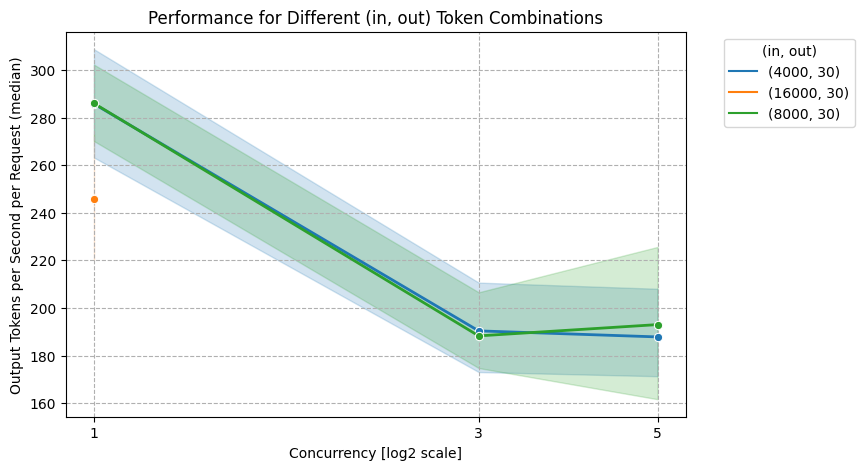

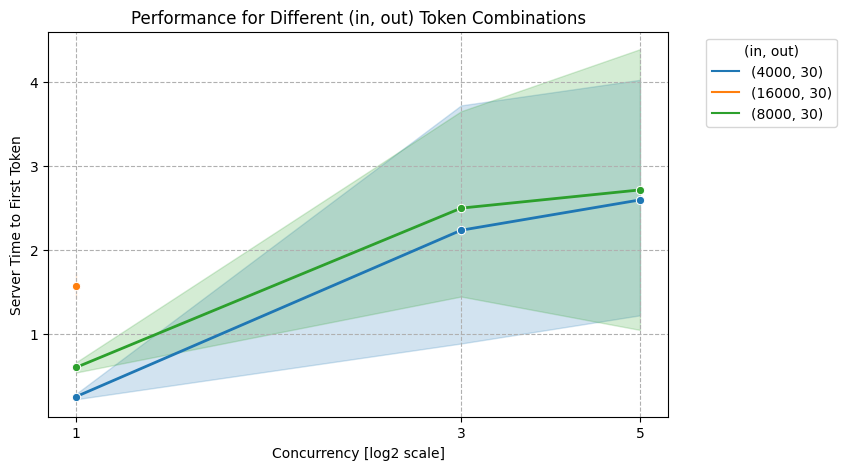

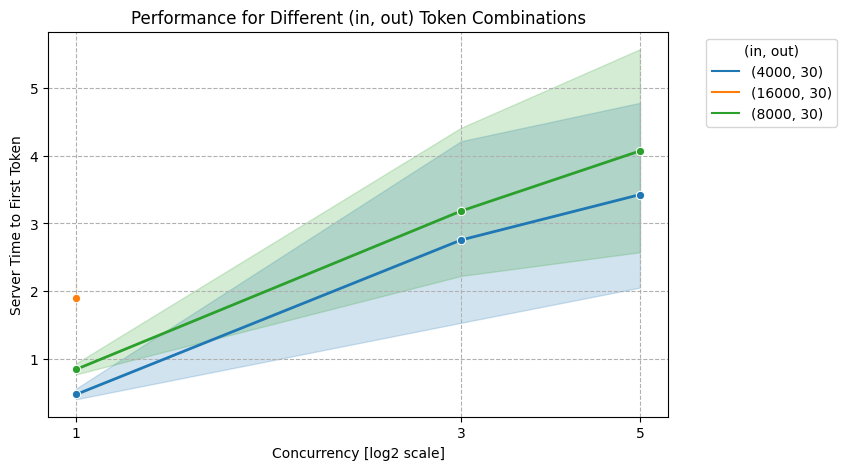

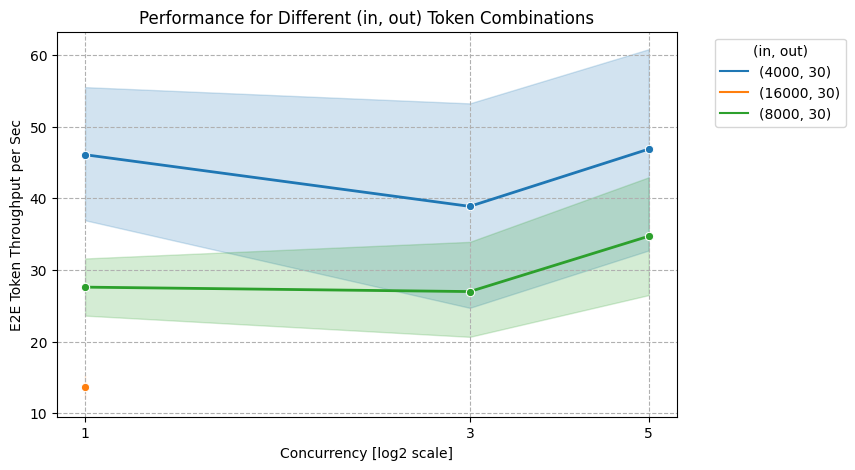

In [6]:
plot_benchmarking_data(df, 'server_output_token_per_s_p50', 'Output Tokens per Second per Request (median)')
plot_benchmarking_data(df, 'server_ttft_s_p50', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_ttft_s_p50', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_mean_output_token_per_s', 'E2E Token Throughput per Sec')


# Analyze switching time

__Note:__ This analysis will work if a Bundle endpoint is used. Users will be able to test and compare performance metrics for different experts.

In [77]:
import re
from typing import Optional

def find_uuid(file_name: str) -> Optional[str]:
    match = re.search(r'[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}', file_name)
    uuid = None
    if match:
        uuid = match.group()
    else:
        raise ValueError(f"UUID not found in filename {file_name}")
        
    return uuid

# post processing individual request json files
def read_json_files_to_df(directory: str) -> pd.DataFrame:
    data = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('individual_responses.json'):
            model_name = '_'.join(filename.split('_')[2:3])
            input_tokens = filename.split('_')[3]
            concurrent_requests = int(filename.split('_')[5])
            file_path = os.path.join(directory, filename)
            # Read the JSON file
            with open(file_path, 'r') as file:
                json_data = json.load(file)
                num_requests = len(json_data)
                # Extract relevant fields from each JSON object and append to the data list
                for item in json_data:
                    if pd.isnull(item['error_code']):
                        data.append(
                            {
                                'start_time': item['start_time'],
                                'end_time': item['end_time'],
                                'server_ttft_s': item['server_ttft_s'],
                                'client_ttft_s': item['client_ttft_s'],
                                'model_name': model_name,
                                'uuid': find_uuid(filename),
                                'input_tokens': input_tokens,
                                'concurrent_requests': concurrent_requests,
                                'filename': filename,
                                'num_requests': num_requests,
                            }
                        )

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)
    return df

# Get the DataFrame
df = read_json_files_to_df(results_dir)
# df_2 = read_json_files_to_df(results_dir_2)

# df = pd.concat([df_1, df_2], ignore_index=True)

# transforming str to date time for sorting
df['start_time'] = pd.to_datetime(df['start_time'])
df = df.sort_values(by=['start_time'])

# transforming back to str for plotting
df['start_time_short'] = df['start_time'].dt.strftime(date_format='%H:%M:%S')
df.head(10)

,start_time,end_time,server_ttft_s,client_ttft_s,model_name,uuid,input_tokens,concurrent_requests,filename,num_requests,start_time_short
1995,2025-08-12 18:57:34.050066,18:57:35.415111,0.143164,1.282274,Meta-Llama-3-1-8B-Instruct,1fa63f7f-1826-4c0c-ba0d-f8eab0ad0556,3900,1,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,1,18:57:34
533,2025-08-12 18:57:36.340103,18:57:37.608744,0.368669,1.165938,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36
535,2025-08-12 18:57:36.340345,18:57:38.132438,0.305100,1.689512,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36
536,2025-08-12 18:57:36.340481,18:57:38.134498,0.305100,1.691886,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36
534,2025-08-12 18:57:36.341379,18:57:37.607350,0.368669,1.165379,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36
3548,2025-08-12 18:57:39.080889,18:57:40.075886,0.082798,0.907141,Meta-Llama-3-1-8B-Instruct,5d7c3615-df81-4a99-9a1e-ea63bd184ade,3900,8,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,8,18:57:39
3553,2025-08-12 18:57:39.081063,18:57:40.956420,0.654226,1.742231,Meta-Llama-3-1-8B-Instruct,5d7c3615-df81-4a99-9a1e-ea63bd184ade,3900,8,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,8,18:57:39
3551,2025-08-12 18:57:39.081764,18:57:40.955881,0.654226,1.739588,Meta-Llama-3-1-8B-Instruct,5d7c3615-df81-4a99-9a1e-ea63bd184ade,3900,8,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,8,18:57:39
3554,2025-08-12 18:57:39.081989,18:57:40.957356,0.654226,1.741924,Meta-Llama-3-1-8B-Instruct,5d7c3615-df81-4a99-9a1e-ea63bd184ade,3900,8,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,8,18:57:39
3549,2025-08-12 18:57:39.082364,18:57:40.952956,0.654226,1.738874,Meta-Llama-3-1-8B-Instruct,5d7c3615-df81-4a99-9a1e-ea63bd184ade,3900,8,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,8,18:57:39


In [78]:
# get df start times lower than 00:00:00
def get_start_times_lower_greater_than(df, time_str, type):
    # Convert the time_str to a datetime object for comparison
    time_obj = pd.to_datetime(time_str, format='%H:%M:%S').time()
    
    if type == 'lt':
        # Filter the DataFrame
        filtered_df = df[df['start_time'].apply(lambda x: pd.to_datetime(x, format='%H:%M:%S').time()) < time_obj]
    elif type == 'gt':
        filtered_df = df[df['start_time'].apply(lambda x: pd.to_datetime(x, format='%H:%M:%S').time()) > time_obj]
    else:
        return None
    return filtered_df

df_first_part = get_start_times_lower_greater_than(df, '22:00:00', 'gt')
df_first_part['start_time'] = df_first_part['start_time'].apply(lambda dt: dt.replace(day=5))

df_second_part = get_start_times_lower_greater_than(df, '22:00:00', 'lt')

df = pd.concat([df_first_part, df_second_part])

# Convert datetime to full string with microseconds
df['start_time_str'] = df['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')

df.head(10)

,start_time,end_time,server_ttft_s,client_ttft_s,model_name,uuid,input_tokens,concurrent_requests,filename,num_requests,start_time_short,start_time_str
1995,2025-08-12 18:57:34.050066,18:57:35.415111,0.143164,1.282274,Meta-Llama-3-1-8B-Instruct,1fa63f7f-1826-4c0c-ba0d-f8eab0ad0556,3900,1,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,1,18:57:34,2025-08-12 18:57:34.050066
533,2025-08-12 18:57:36.340103,18:57:37.608744,0.368669,1.165938,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36,2025-08-12 18:57:36.340103
535,2025-08-12 18:57:36.340345,18:57:38.132438,0.305100,1.689512,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36,2025-08-12 18:57:36.340345
536,2025-08-12 18:57:36.340481,18:57:38.134498,0.305100,1.691886,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36,2025-08-12 18:57:36.340481
534,2025-08-12 18:57:36.341379,18:57:37.607350,0.368669,1.165379,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36,2025-08-12 18:57:36.341379
3548,2025-08-12 18:57:39.080889,18:57:40.075886,0.082798,0.907141,Meta-Llama-3-1-8B-Instruct,5d7c3615-df81-4a99-9a1e-ea63bd184ade,3900,8,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,8,18:57:39,2025-08-12 18:57:39.080889
3553,2025-08-12 18:57:39.081063,18:57:40.956420,0.654226,1.742231,Meta-Llama-3-1-8B-Instruct,5d7c3615-df81-4a99-9a1e-ea63bd184ade,3900,8,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,8,18:57:39,2025-08-12 18:57:39.081063
3551,2025-08-12 18:57:39.081764,18:57:40.955881,0.654226,1.739588,Meta-Llama-3-1-8B-Instruct,5d7c3615-df81-4a99-9a1e-ea63bd184ade,3900,8,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,8,18:57:39,2025-08-12 18:57:39.081764
3554,2025-08-12 18:57:39.081989,18:57:40.957356,0.654226,1.741924,Meta-Llama-3-1-8B-Instruct,5d7c3615-df81-4a99-9a1e-ea63bd184ade,3900,8,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,8,18:57:39,2025-08-12 18:57:39.081989
3549,2025-08-12 18:57:39.082364,18:57:40.952956,0.654226,1.738874,Meta-Llama-3-1-8B-Instruct,5d7c3615-df81-4a99-9a1e-ea63bd184ade,3900,8,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,8,18:57:39,2025-08-12 18:57:39.082364


In [79]:
# Initialize a column for the switching time
df['server_switching_time'] = None

# Group by model_name
grouped = df.groupby('uuid')

# Iterate through each group to calculate switching time
for name, group in grouped:
    if len(group) > 1:
        first_ttft = group['server_ttft_s'].iloc[0]
        mean_ttft = group['server_ttft_s'].iloc[1:].mean()
        std_ttft = group['server_ttft_s'].iloc[1:].std()
        std_ttft = 1e-16 if np.isnan(std_ttft) else std_ttft
        switching_time = first_ttft - mean_ttft
        if switching_time > (mean_ttft + 3 * std_ttft):
            df.loc[group.index[0], 'server_switching_time'] = switching_time
        else:
            None
    else:
        df.loc[group.index[0], 'server_switching_time'] = None

# with pd.option_context(
#     'display.max_rows',
#     None,
# ):
#     display(df)

In [80]:
from typing import List, Tuple, Optional
def extract_file_info(file_name: str) -> Tuple[str, int, int, Optional[int], Optional[float]]:
    """Extract model, input, output, and concurrency from file name."""

    if 'multimodal' in file_name:
        _, _, model, _, _, in_tok, out_tok, con_type, *_ = file_name.split('_')
    else:
        _, _, model, in_tok, out_tok, con_type, *_ = file_name.split('_')

    if 'synthetic' in file_name:
        con = int(con_type)
        qps = None
    elif 'realworkload' in file_name:
        con = None
        qps = float(con_type.replace('-', '.'))

    return model, int(in_tok), int(out_tok), con, qps

def get_grouping_and_batching_info(df: pd.DataFrame) -> Tuple[List[int], List[int]]:
    """Generate grouping and batching info from DataFrame."""
    df = df.sort_values('end_time').reset_index(drop=True)
    df['group'] = (df['server_ttft_s'] != df['server_ttft_s'].shift()).cumsum()

    consecutive_counts = df.groupby(['group', 'server_ttft_s']).size().reset_index(name='consecutive_count')
    requests_grouping = consecutive_counts['consecutive_count'].tolist()
    requests_batching = [1 << (x - 1).bit_length() for x in requests_grouping]

    return requests_grouping, requests_batching

def find_uuid(file_name: str) -> Optional[str]:
    match = re.search(r'[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}', file_name)
    uuid = None
    if match:
        uuid = match.group()
    else:
        raise ValueError(f"UUID not found in filename {file_name}")
        
    return uuid

dict_groupings = {}

for filename in os.listdir(results_dir):
    if 'individual_responses' in filename:
        model_finame: str
        in_tok_finame: int
        out_tok_finame: int
        concurrency_finame: Optional[int]
        qps_finame: Optional[float]

        # model_finame, in_tok_finame, out_tok_finame, concurrency_finame, qps_finame = extract_file_info(
        #     filename
        # )
                
        df_file = df[df['filename'] == filename].copy()
        # df_file = df_file[df_file['error_code'].isnull()]

        requests_grouping, requests_batching = get_grouping_and_batching_info(df_file)
        
        dict_groupings[filename] = {
            'requests_grouping': requests_grouping,
            'requests_batching': requests_batching
        }
        
df_groupings = pd.DataFrame.from_dict(dict_groupings).T
df = df.merge(df_groupings, left_on='filename', right_index=True, how='left')
df

,start_time,end_time,server_ttft_s,client_ttft_s,model_name,uuid,input_tokens,concurrent_requests,filename,num_requests,start_time_short,start_time_str,server_switching_time,requests_grouping,requests_batching
1995,2025-08-12 18:57:34.050066,18:57:35.415111,0.143164,1.282274,Meta-Llama-3-1-8B-Instruct,1fa63f7f-1826-4c0c-ba0d-f8eab0ad0556,3900,1,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,1,18:57:34,2025-08-12 18:57:34.050066,None,[1],[1]
533,2025-08-12 18:57:36.340103,18:57:37.608744,0.368669,1.165938,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36,2025-08-12 18:57:36.340103,None,"[2, 2]","[2, 2]"
535,2025-08-12 18:57:36.340345,18:57:38.132438,0.305100,1.689512,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36,2025-08-12 18:57:36.340345,None,"[2, 2]","[2, 2]"
536,2025-08-12 18:57:36.340481,18:57:38.134498,0.305100,1.691886,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36,2025-08-12 18:57:36.340481,None,"[2, 2]","[2, 2]"
534,2025-08-12 18:57:36.341379,18:57:37.607350,0.368669,1.165379,Meta-Llama-3-1-8B-Instruct,a8390770-ff07-4c91-ac87-4af3e0c0ba4c,3900,4,synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...,4,18:57:36,2025-08-12 18:57:36.341379,None,"[2, 2]","[2, 2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,2025-08-12 20:30:53.049235,20:30:58.307349,2.986465,5.017375,legml-v0-1,4e931ead-f111-45f8-a77a-c79e75b7887e,8000,8,synthetic_0_legml-v0-1_8000_100_8_stream_4e931...,32,20:30:53,2025-08-12 20:30:53.049235,None,"[2, 6, 2, 6, 2, 5, 3, 5, 1]","[2, 8, 2, 8, 2, 8, 4, 8, 1]"
1305,2025-08-12 20:30:53.069837,20:30:58.312356,2.986465,4.996118,legml-v0-1,4e931ead-f111-45f8-a77a-c79e75b7887e,8000,8,synthetic_0_legml-v0-1_8000_100_8_stream_4e931...,32,20:30:53,2025-08-12 20:30:53.069837,None,"[2, 6, 2, 6, 2, 5, 3, 5, 1]","[2, 8, 2, 8, 2, 8, 4, 8, 1]"
1303,2025-08-12 20:30:53.081212,20:30:58.311837,2.986465,4.984824,legml-v0-1,4e931ead-f111-45f8-a77a-c79e75b7887e,8000,8,synthetic_0_legml-v0-1_8000_100_8_stream_4e931...,32,20:30:53,2025-08-12 20:30:53.081212,None,"[2, 6, 2, 6, 2, 5, 3, 5, 1]","[2, 8, 2, 8, 2, 8, 4, 8, 1]"
1304,2025-08-12 20:30:53.084227,20:30:58.312229,2.986465,4.979997,legml-v0-1,4e931ead-f111-45f8-a77a-c79e75b7887e,8000,8,synthetic_0_legml-v0-1_8000_100_8_stream_4e931...,32,20:30:53,2025-08-12 20:30:53.084227,None,"[2, 6, 2, 6, 2, 5, 3, 5, 1]","[2, 8, 2, 8, 2, 8, 4, 8, 1]"


In [127]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

model_family = {
    'Llama-8b': [
        'Meta-Llama-3-1-8B-Instruct',
        'Hermes-3-Llama-3-1-8B',
        'LLaMa3-1-8B-Legal-ThaiCCL-Combine',
        'Llama-3-1-8B-Magpie-Align-SFT-v0-2',
        'Llama-3-1-EIRAI-8B',
        'Llama-3-1-OpenScholar-8B',
        'natsumura-assistant-1-0-llama-3-1-8b',
        'llama-3-1-tulu-2-8b',
        'narrativAIV2',
        'Llama-3-1-Storm-8B'
    ],
    'Qwen-32b': [
        'Qwen3-32B',
        'DMind-1',
        'DeepSWE-Preview',
        'Gazal-R1-32B-sft-merged-preview',
        'INFIndo-Qwen3-32B-Preview',
        'Qwen3-32B-abliterated',
        'Qwen3-32B-bf16',
        'Qwen3-32B-Copy',
        'Smoothie-Qwen3-32B',
        'UIGEN-T3-32B-Preview'
    ],
    'Qwen-14b': [
        'Qwen2-5-14B',
        '14B-Qwen2-5-Freya-x1',
        'EVA-Qwen2-5-14B-v0-0',
        'General-Reasoner-Qwen2-5-14B',
        'Qwen2-5-Coder-14B',
        'SauerkrautLM-v2-14b-SFT',
        'SuperNova-Medius',
        'Tsunami-1-0-14B-Instruct',
        'Virtuoso-Small',
        'legml-v0-1'
    ]
}

# Create config column for every row
df['config'] = df[['model_name', 'input_tokens', 'concurrent_requests']] \
    .apply(lambda x: f'{x[0]}-{x[1]}-{x[2]}', axis=1)

df = df.sort_values(by='start_time_str').reset_index(drop=True)
uuids_per_family = {}

for family_name, members in model_family.items():
    df_family = df[df['model_name'].isin(members)].copy().reset_index(drop=True)
    if df_family.empty:
        print(f"⚠️ No data for {family_name}, skipping...")
        continue

    # Identify switch point for this family
    switch_idx = df_family[(df_family['num_requests'] == 4) &
                           (df_family['concurrent_requests'] == 1)].index.min()
    
    # Filter df_family with records that start with switch_idx
    if switch_idx != -1:
        df_family_filtered = df_family[df_family.index >= switch_idx] 
    uuids_per_family[family_name] = df_family_filtered['uuid'].unique()
    
    if pd.isna(switch_idx):
        print(f"⚠️ No switch point found for {family_name}, skipping...")
        continue

    # Add numeric index for plotting
    df_family['time_idx'] = range(len(df_family))

    # Create scatter plot with config shown in hover for all points
    fig = px.scatter(
        df_family,
        x="time_idx",
        y="server_ttft_s",
        color="config",
        hover_data=[
            "model_name",
            "input_tokens",
            "concurrent_requests",
            "start_time_str",
            "uuid",
            "config"  # show for every point
        ],
        title=f"Scatter Plot of Server TTFT Over Time — {family_name}",
        labels={"time_idx": "Request Index", "server_ttft_s": "Server TTFT (s)"}
    )

    # Warm-up zone
    fig.add_vrect(
        x0=0, x1=switch_idx - df_family.index.min(),
        fillcolor="orange", opacity=0.1,
        annotation_text="Warm up zone", annotation_position="top left"
    )

    # Switching time zone
    fig.add_vrect(
        x0=switch_idx - df_family.index.min(), x1=len(df_family) - 1,
        fillcolor="blue", opacity=0.05,
        annotation_text="Switching time zone", annotation_position="top left"
    )

    # Custom hovertemplate to display config nicely
    fig.update_traces(
        hovertemplate=(
            "<b>Model config: %{customdata[5]}</b><extra></extra><br>"
            "Server TTFT (s): %{y}<br>"
            "Model: %{customdata[0]}<br>"
            "Input Tokens: %{customdata[1]}<br>"
            "Concurrent Requests: %{customdata[2]}<br>"
            "Start Time: %{customdata[3]}<br>"
        )
    )

    # Custom x-axis with timestamps
    fig.update_xaxes(
        tickvals=df_family['time_idx'][::max(1, len(df_family) // 20)],
        ticktext=df_family['start_time_str'][::max(1, len(df_family) // 20)],
        tickangle=90
    )

    # Layout settings
    fig.update_layout(
        yaxis_autorange=True,
        legend_title="Model Name + SS + Batch size",
        legend=dict(x=1.02, y=1, bgcolor="rgba(255,255,255,0.8)"),
        margin=dict(l=40, r=200, t=60, b=120),
        hovermode="closest"
    )

    # Show in browser and save
    fig.show(renderer="browser")
    file_name = f"scatter_plot_{family_name}.html"
    pio.write_html(fig, file_name)
    print(f"✅ Saved: {file_name}")


✅ Saved: scatter_plot_Llama-8b.html
✅ Saved: scatter_plot_Qwen-32b.html
✅ Saved: scatter_plot_Qwen-14b.html


In [128]:
parent_dir = os.path.dirname(results_dir)
current_run = results_dir.split('/')[-1]
consolidated_results_path = os.path.join(parent_dir,f'consolidated_results/consolidated_results_{current_run}.xlsx')


df_consolidated_results = pd.read_excel(consolidated_results_path)
df_consolidated_results['model'] = df_consolidated_results.model.str.replace('_', '-')

In [131]:
import pandas as pd
import plotly.express as px
import plotly.subplots as sp

# --- Create combined model-num_input_tokens column ---
df_consolidated_results["model_token"] = (
    df_consolidated_results["model"] + "-" + df_consolidated_results["num_input_tokens"].astype(str)
)

# --- Sort by num_input_tokens then model ---
df_consolidated_results = df_consolidated_results.sort_values(by=["num_input_tokens", "model"])

# --- Create figures per model family ---
for family_name, models in model_family.items():
    df_family = df_consolidated_results[df_consolidated_results["model"].isin(models)]
    df_family = df_family[df_family.uuid.isin(uuids_per_family[family_name])]

    num_concurrents = sorted(df_family["num_concurrent_requests"].unique())
    fig = sp.make_subplots(
        rows=len(num_concurrents),
        cols=2,
        shared_xaxes=False,
        vertical_spacing=0.20,  # much more vertical space between rows
        subplot_titles=[
            f"TTFT - {family_name} (Batch Size={ncr})" if i % 2 == 0 else f"Output tok/s - {family_name} (Batch Size={ncr})"
            for ncr in num_concurrents for i in range(2)
        ]
    )

    for row_idx, ncr in enumerate(num_concurrents, start=1):
        df_row = df_family[df_family["num_concurrent_requests"] == ncr]

        # Col 1
        fig1 = px.line(
            df_row,
            x="model_token",
            y="server_ttft_s_p50",
            color="num_input_tokens",
            markers=True
        )
        for trace in fig1.data:
            fig.add_trace(trace, row=row_idx, col=1)

        # Col 2
        fig2 = px.line(
            df_row,
            x="model_token",
            y="server_output_token_per_s_p50",
            color="num_input_tokens",
            markers=True
        )
        for trace in fig2.data:
            fig.add_trace(trace, row=row_idx, col=2)

    # Rotate all x labels, add standoff, and prevent clipping
    fig.update_xaxes(
        tickangle=60,
        automargin=True,
        title_standoff=20  # extra space between labels and axis line
    )

    # Legend on the left, vertical
    fig.update_layout(
        height=500 * len(num_concurrents),
        width=1500,
        title_text=f"Performance Plots for {family_name}",
        showlegend=True,
        legend=dict(
            orientation="v",   # vertical
            yanchor="middle",  # center vertically
            y=0.5,              # middle of plot
            xanchor="left",
            x=-0.15             # to the left of plots
        ),
        margin=dict(t=120, b=180, l=150, r=40)  # extra left margin for legend
    )

    fig.show(renderer="browser")
    file_name = f"{family_name}_performance_plots.html"
    pio.write_html(fig, file_name)
    print(f"✅ Saved: {file_name}")


✅ Saved: Llama-8b_performance_plots.html
✅ Saved: Qwen-32b_performance_plots.html
✅ Saved: Qwen-14b_performance_plots.html
